In [32]:
import DicomPipeLine 
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import imageio
import scipy.ndimage as ndi 

import time
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from skimage.transform import resize

def normalize(img_array):
    return cv2.normalize(img_array, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)

In [19]:
main_data_source_path = r'C:\Users\vikra\Codes\Tumor_Codes\Final_Project_git\Liver tumor'

In [20]:
preprocessed_data_path = r'C:\Users\vikra\Codes\Tumor_Codes\Final_Project_git\Preprocessed'

In [21]:
sub_folders_to_scan_for = ['2','3','4','5']

In [22]:
path_obj = DicomPipeLine.Path_Settings(main_data_source_path, preprocessed_data_path, sub_folders_to_scan_for)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2003.01it/s]

- Found 2 folders with a total of 8 scans


In [23]:
path_obj.Refresh()

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2002.05it/s]

- Found 2 folders with a total of 8 scans


In [24]:
streamer = DicomPipeLine.Stream_Data(path_obj)

In [25]:
ct = streamer.get('1', 'CT PLAIN')[362]
# ct = normalize(ct)

C:\Users\vikra\Codes\Tumor_Codes\Final_Project_git\Preprocessed\1\CT PLAIN.pickle.gzip


#### Procrustes analysis 
Aims to align 2 sets of points (in other words, 2 shapes) to minimize square distance between them by removing scale, translation and rotation warp components.

In [26]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()
    print(ssX)
    print(ssY)

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2
        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    #rot =1
    #scale=2
    #translate=3
    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

<>:75: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:75: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\vikra\AppData\Local\Temp\ipykernel_2248\969204023.py:75: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if reflection is not 'best':


In [52]:
ct_points=[]

In [53]:
pet_points=[]

Specify the number of points

In [54]:
n=5

In [55]:
# Define Click Function
def click_event_ct(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,y)
        ct_points.append([x,y])

In [56]:
cv2.namedWindow('Image CT',cv2.WINDOW_NORMAL)
cv2.resizeWindow('Image CT', 600,600)

n_ct = normalize(ct)
cv2.imshow('Image CT', n_ct)

cv2.setMouseCallback('Image CT', click_event_ct)

cv2.waitKey(0)#press any key to close all windows
cv2.destroyAllWindows()

ct_points

271 115
294 357
433 224
124 245
276 236


[[271, 115], [294, 357], [433, 224], [124, 245], [276, 236]]

In [57]:
# Define Click Function
def click_event_pet(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,y)
        pet_points.append([x,y])

In [58]:
cv2.namedWindow('Image PET',cv2.WINDOW_NORMAL)
cv2.resizeWindow('Image PET', 600,600)

pet_registered = streamer.get('1', 'PET WB  (AC)')[362]
# pet_registered = np.invert(pet_registered)
pet_registered = normalize(pet_registered)

cv2.imshow('Image PET', pet_registered)

cv2.setMouseCallback('Image PET', click_event_pet)

cv2.waitKey(0)#press any key to close all windows
cv2.destroyAllWindows()

pet_points

C:\Users\vikra\Codes\Tumor_Codes\Final_Project_git\Preprocessed\1\PET WB  (AC).pickle.gzip
88 60
90 113
121 83
53 90
89 86


[[88, 60], [90, 113], [121, 83], [53, 90], [89, 86]]

#### Specifying the co-ordinates

In [59]:
X_pts = np.asarray(ct_points)
Y_pts = np.asarray(pet_points)
print(X_pts)

[[271 115]
 [294 357]
 [433 224]
 [124 245]
 [276 236]]


In [60]:
d,Z_pts,Tform = procrustes(X_pts,Y_pts)

77542.40000000001
3747.9999999999995


In [61]:
R = np.eye(3)

In [62]:
Tform

{'rotation': array([[ 9.99999994e-01,  1.05760417e-04],
        [-1.05760417e-04,  9.99999994e-01]]),
 'scale': 4.54098188238644,
 'translation': array([-120.87310566, -156.98319104])}

In [63]:
R[0:2,0:2] = Tform['rotation']

In [64]:
S = np.eye(3) * Tform['scale'] 
S[2,2] = 1
t = np.eye(3)
t[0:2,2] = Tform['translation']
M = np.dot(np.dot(R,S),t.T).T
h=ct.shape[0]
w=ct.shape[1]
tr_Y_img = cv2.warpAffine(pet_registered,M[0:2,:],(h,w))
tr_Y_img_1 = np.invert(tr_Y_img)
cv2.imwrite(r"C:\Users\vikra\Codes\Tumor_Codes\Final_Project_git\Liver_Tumor_Metabolism_Detection\Registered\pet_registered_2.png", tr_Y_img_1) 

True

In [65]:
aY_pts = np.hstack((Y_pts,np.array(([[1,1,1,1,1]])).T))
tr_Y_pts = np.dot(M,aY_pts.T).T

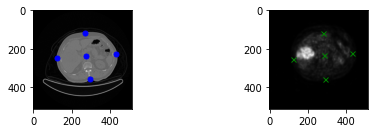

In [66]:
plt.figure() 
plt.subplot(1,3,1)
plt.imshow(ct,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=5)
# plt.axis('off')
# plt.subplot(1,3,2)
# plt.imshow(pet_registered,cmap=cm.gray)
# plt.plot(Y_pts[:,0],Y_pts[:,1],'ro',markersize=5)
# plt.axis('off')
plt.subplot(1,3,3)
# plt.imshow(ct_fixed,cmap=cm.gray)
plt.imshow(tr_Y_img,cmap=cm.gray)
# plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=5) 
# plt.plot(Z_pts[:,0],Z_pts[:,1],'ro',markersize=5)
plt.plot(tr_Y_pts[:,0],tr_Y_pts[:,1],'gx',markersize=5)
# plt.axis('off')
plt.show()

# FUSION

In [70]:
fuse = normalize(tr_Y_img_1 + n_ct)

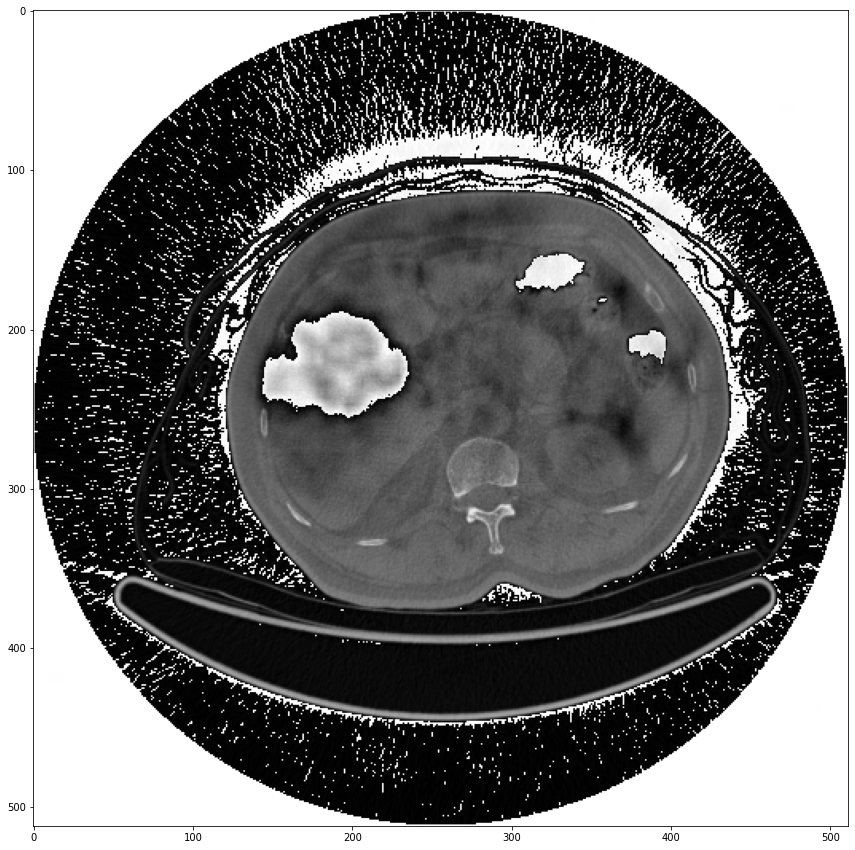

In [78]:
plt.figure(figsize=(15,15))
plt.imshow(fuse, cmap='gray')

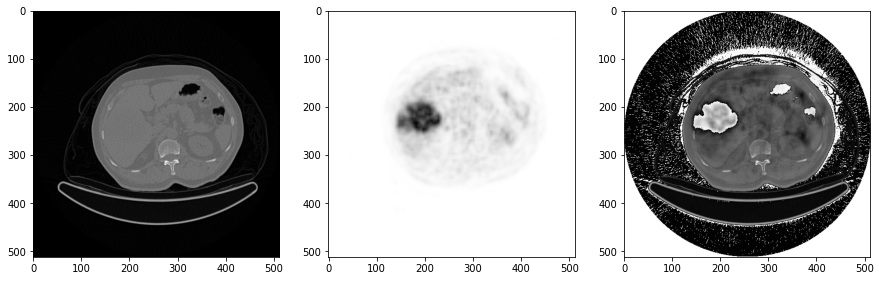

In [79]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(n_ct, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(tr_Y_img_1, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(fuse, cmap='gray')